<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Copy_of_CNN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]


['PaperedControl20v_light.tif',
 'PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif']

In [ ]:
train_images=[]
for filename in filenames:
    if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 801


In [ ]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [ ]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('Marked')
    if filename.startswith('NoPapered'):
        categories.append('NotMarked')
len(categories)

801

In [ ]:

df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20v_light.tif,Marked
1,PaperedControl20d.tif,Marked
2,PaperedControl20d_light.tif,Marked
3,PaperedControl21v.tif,Marked
4,PaperedControl21v_light.tif,Marked
...,...,...
796,PaperedControl18v.tif,Marked
797,PaperedControl18d.tif,Marked
798,PaperedControl19v.tif,Marked
799,PaperedControl19d.tif,Marked


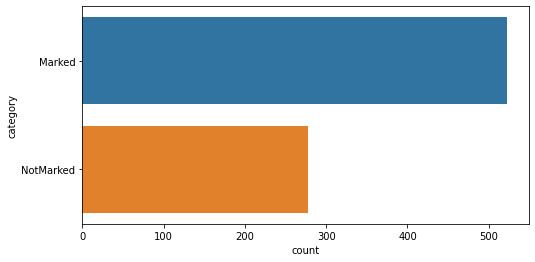

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [ ]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df.sample(9)
tmp_df

,filename,category
139,PaperedControl77d.tif,Marked
137,PaperedControl76d_light.tif,Marked
794,PaperedControl17v.tif,Marked
342,PaperedTransparent93v.tif,Marked
719,PaperedMixed47v.tif,Marked
112,PaperedControl66d.tif,Marked
668,PaperedMixed21d.tif,Marked
2,PaperedControl20d_light.tif,Marked
649,PaperedMixed12v.tif,Marked


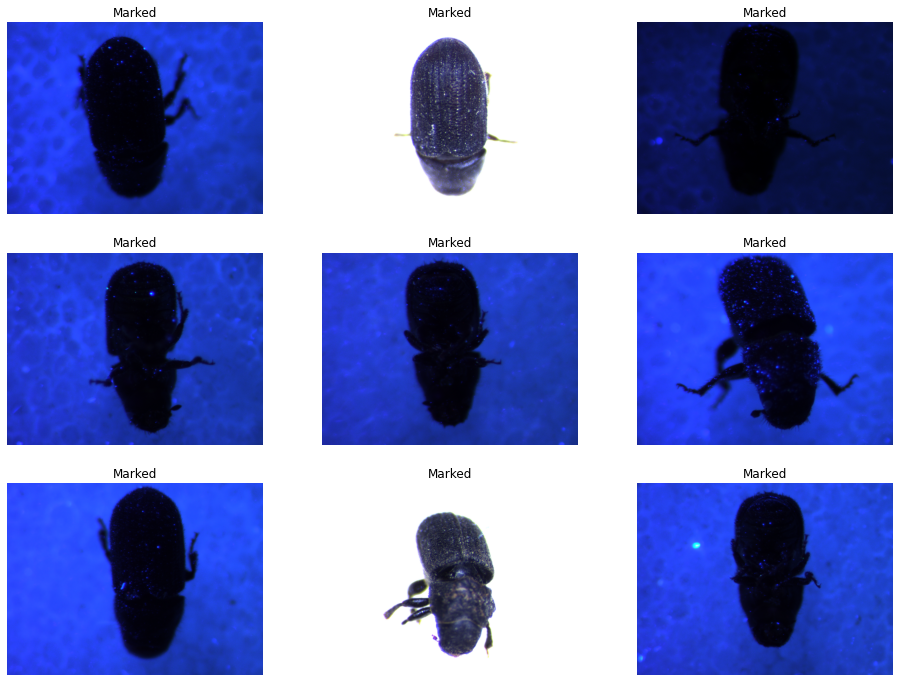

In [ ]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

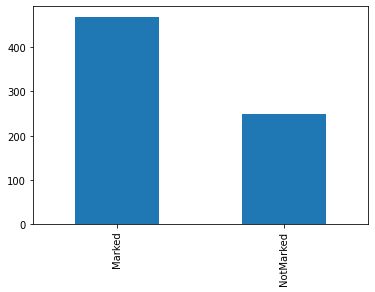

In [ ]:
train_df['category'].value_counts().plot.bar()

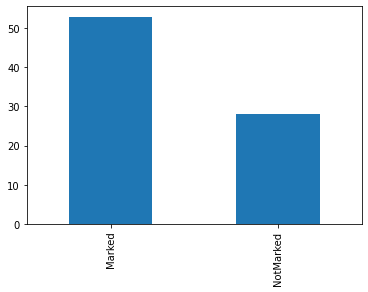

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [ ]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [ ]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 720 validated image filenames belonging to 2 classes.


In [ ]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 81 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

def create_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(456, 456, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(2, activation = 'softmax'))
  return model

leaf_model = create_model()
leaf_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 454, 454, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 454, 454, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 227, 227, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 227, 227, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 225, 225, 64)      18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 225, 225, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)     

In [ ]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [ ]:
results = Model_fit()

Epoch 1/50
48/48 [==============================] - 1126s 23s/step - loss: 1.6938 - categorical_accuracy: 0.6575 - val_loss: 1.1310 - val_categorical_accuracy: 0.7333
Epoch 2/50
48/48 [==============================] - 634s 13s/step - loss: 0.6350 - categorical_accuracy: 0.7602 - val_loss: 1.7062 - val_categorical_accuracy: 0.5333
Epoch 3/50
48/48 [==============================] - 631s 13s/step - loss: 0.3875 - categorical_accuracy: 0.8389 - val_loss: 1.2139 - val_categorical_accuracy: 0.6000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/50
48/48 [==============================] - 638s 13s/step - loss: 0.4826 - categorical_accuracy: 0.7967 - val_loss: 1.1447 - val_categorical_accuracy: 0.6400
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [ ]:
model.save_weights("model.h5")